In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
np.random.SEED = 42

In [2]:
n_samples = 5 * np.ones(4, dtype=int)
dose = np.array([-0.86,-0.3,-.05,.73])
deaths = np.array([0,1,3,5])

In [3]:
def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

In [4]:
def p_posterior(alpha,beta,dose,obs_deaths,n):
    p = []
    for dose_i,obs_deaths_i,n_i in zip(dose,obs_deaths,n):
        theta_i = invlogit(alpha+beta*dose_i)
        p.append(theta_i**obs_deaths_i*(1-theta_i)**(n_i-obs_deaths_i))
    p = np.array(p)
    return np.prod(p,axis=0)
        

In [5]:
delta = 0.1
alpha = np.arange(-5.0,10+delta,delta)
beta = np.arange(-10,40+delta,delta)

ALPHA, BETA = np.meshgrid(alpha,beta)
p = p_posterior(ALPHA, BETA, dose, deaths, n_samples)

(0, 25)

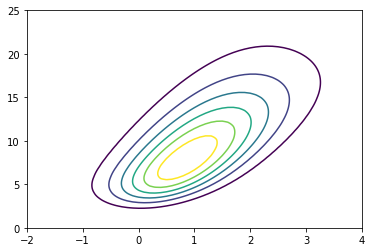

In [6]:
plt.figure()
CS = plt.contour(ALPHA,BETA,p)
plt.xlim((-2,4))
plt.ylim((0,25))

In [7]:
alpha_marg = np.mean(p,axis=0)
beta_marg = np.mean(p,axis=1)

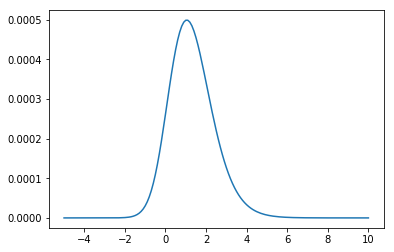

In [8]:
plt.plot(alpha,alpha_marg)

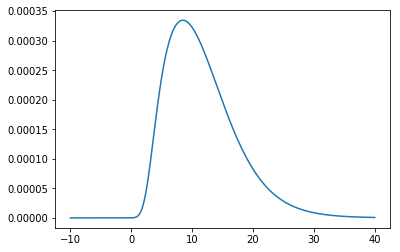

In [9]:
plt.plot(beta, beta_marg)

In [10]:
def inv_cdf(pdf,x):
    cdf = [integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf = np.array([0] + cdf)
    cdf = cdf / cdf[-1]
    return interpolate.interp1d(cdf,x)

In [11]:
n = 1000
sample_alpha = np.random.random_sample(n)
sample_beta = np.random.random_sample(n)

alpha_sample = inv_cdf(alpha_marg,alpha)(sample_alpha)

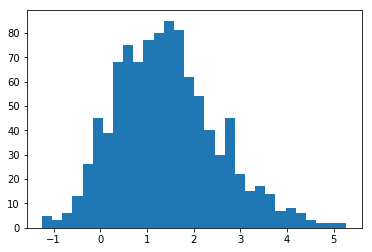

In [12]:
_ = plt.hist(alpha_sample,bins=30)

In [13]:
beta_sample = []

for alp,bet in zip(alpha_sample,sample_beta):
    bet_dis = p_posterior(alp,beta,dose,deaths,n_samples)
    b_sample = inv_cdf(bet_dis,beta)(bet)
    beta_sample.append(b_sample)

beta_sample = np.array(beta_sample)

(array([106., 252., 233., 180., 118.,  61.,  29.,  15.,   2.,   4.]),
 array([ 1.9131953 ,  5.44417491,  8.97515451, 12.50613411, 16.03711371,
        19.56809332, 23.09907292, 26.63005252, 30.16103213, 33.69201173,
        37.22299133]),
 <a list of 10 Patch objects>)

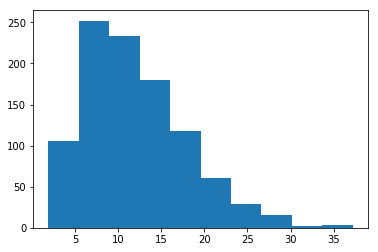

In [14]:
beta_sample = np.array(beta_sample)
plt.hist(beta_sample)

In [15]:
ld50 = -alpha_sample/beta_sample

(array([  1.,   0.,   2.,   5.,   1.,   5.,  13.,  29.,  47.,  69., 136.,
        159., 148., 130., 109.,  48.,  38.,  24.,  12.,  12.,   3.,   5.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([-0.46820124, -0.43955159, -0.41090194, -0.3822523 , -0.35360265,
        -0.324953  , -0.29630335, -0.26765371, -0.23900406, -0.21035441,
        -0.18170476, -0.15305512, -0.12440547, -0.09575582, -0.06710617,
        -0.03845653, -0.00980688,  0.01884277,  0.04749242,  0.07614206,
         0.10479171,  0.13344136,  0.16209101,  0.19074065,  0.2193903 ,
         0.24803995,  0.2766896 ,  0.30533924,  0.33398889,  0.36263854,
         0.39128819]),
 <a list of 30 Patch objects>)

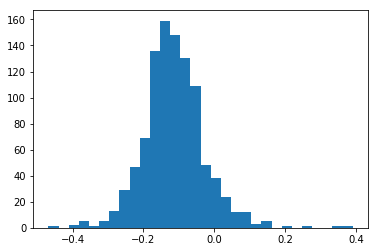

In [16]:
plt.hist(ld50,bins=30)

In [17]:
print(np.percentile(ld50,[2.5,25,50,75,97.5]))

[-0.27041133 -0.16471158 -0.11868003 -0.0668156   0.06132896]


In [18]:
n = 1000
proposal = np.random.multivariate_normal([0,0],[[1,0],[0,5]],n)

alpha_mc = 4.0
beta_mc = 42.0
p_mc = p_posterior(alpha_mc,beta_mc,dose,deaths,n_samples)

alpha_chain = [alpha_mc]
beta_chain = [beta_mc]

for dev_a,dev_b in proposal:
    alpha_proposal = alpha_mc + dev_a
    beta_proposal = beta_mc + dev_b
    p_proposal = p_posterior(alpha_proposal,beta_proposal,dose,deaths,n_samples)
    if (p_proposal>=p_mc) or (np.random.random()<p_proposal/p_mc):
        alpha_mc = alpha_proposal
        beta_mc = beta_proposal
        p_mc = p_proposal
    alpha_chain.append(alpha_mc)
    beta_chain.append(beta_mc)

    

In [19]:
alpha_chain = np.array(alpha_chain)
beta_chain = np.array(beta_chain)

In [20]:
ld50_mcmc = -alpha_chain/beta_chain

(array([0.03156662, 0.        , 0.        , 0.34723286, 0.        ,
        0.15783312, 0.18939974, 0.59976585, 0.72603235, 2.14653041,
        2.20966366, 6.02922513, 4.95595992, 4.73499356, 3.0619625 ,
        1.89399742, 1.42049807, 1.10483183, 0.59976585, 0.28409961,
        0.31566624, 0.37879948, 0.18939974, 0.06313325, 0.09469987,
        0.        , 0.03156662, 0.        , 0.        , 0.03156662]),
 array([-0.50833353, -0.47668614, -0.44503876, -0.41339138, -0.381744  ,
        -0.35009662, -0.31844923, -0.28680185, -0.25515447, -0.22350709,
        -0.19185971, -0.16021232, -0.12856494, -0.09691756, -0.06527018,
        -0.0336228 , -0.00197541,  0.02967197,  0.06131935,  0.09296673,
         0.12461411,  0.1562615 ,  0.18790888,  0.21955626,  0.25120364,
         0.28285102,  0.31449841,  0.34614579,  0.37779317,  0.40944055,
         0.44108793]),
 <a list of 30 Patch objects>)

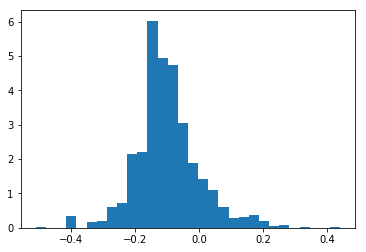

In [21]:
plt.hist(ld50_mcmc,bins=30,density=True)

In [22]:
print(np.percentile(ld50_mcmc[400:],[2.5,25,50,75,97.5]))

[-0.27004116 -0.15179736 -0.10292303 -0.04296324  0.1681752 ]


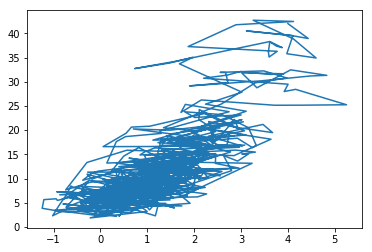

In [23]:
plt.plot(alpha_chain,beta_chain)

In [28]:
n = 1000
alpha_mc = 4.0
beta_mc = 42.0

gibbs_alpha = [alpha_mc]
gibbs_beta = [beta_mc]

vary_alpha = True
for i in range(n):
    if vary_alpha:
        bet_dis = p_posterior(alpha_mc,beta,dose,deaths,n_samples)
        beta_mc = inv_cdf(bet_dis,beta)(np.random.random())
        gibbs_alpha.append(alpha_mc)
        gibbs_beta.append(beta_mc)
        vary_alpha = not vary_alpha
    else:
        alpha_dis = p_posterior(alpha,beta_mc,dose,deaths,n_samples)
        alpha_mc = inv_cdf(alpha_dis,alpha)(np.random.random())
        gibbs_alpha.append(alpha_mc)
        gibbs_beta.append(beta_mc)
        vary_alpha = not vary_alpha

gibbs_alpha = np.array(gibbs_alpha)
gibbs_beta = np.array(gibbs_beta)

ld50_gibbs = -gibbs_alpha/gibbs_beta

    

[-0.32299151 -0.17550064 -0.13017324 -0.0823193   0.00485278]


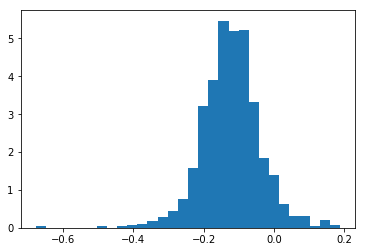

In [29]:
plt.hist(ld50_gibbs,bins=30,density=True)
print(np.percentile(ld50_gibbs[:400],[2.5,25,50,75,97.5]))

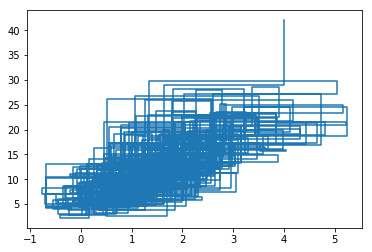

In [30]:
plt.plot(gibbs_alpha,gibbs_beta)